# Self-Organizing Maps (SOMs) Notebook
## Load "winning" SOMs - Step 4

**Notebook by Maria J. Molina (NCAR) and Alice DuVivier (NCAR).**

**Still very much in progress**

This Notebook reads in the pickle files saved as possible "winning" SOMs.

In [1]:
import pandas as pd
from minisom import MiniSom, asymptotic_decay
import xarray as xr
import cftime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from datetime import timedelta
from itertools import product
import seaborn as sns
import pickle
import sammon
import dask

### Set User-specified information

In [2]:
# set paired values for possible winning maps based on Sammon maps
vars_in          = ['aice_d', 'aice_d', 'aice_d_hi_d']  # training dataset
som_grid_rows    = [3, 3, 3]    # (y-axis)
som_grid_cols    = [3, 3, 3]    # (x-axis)
sigs             = [1.0, 1.0, 1.0]
lrs              = [0.005, 0.005, 0.005]
nitrs            = [1000000, 100000, 100000]
ranks            = [6, 9, 8]

In [29]:
# MANUAL CHANGING REQUIRED HERE
n = 2
# n = 0-2 (matches sizes set above)

var_in = vars_in[n]
som_row = som_grid_rows[n]
som_col = som_grid_cols[n]
sig = sigs[n]
lr = lrs[n]
n_iter = nitrs[n]
rank = ranks[n]

In [30]:
# set the location of the already extracted training data
sector_short = 'Ross'
path_in = '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/training/'+sector_short+'_v5/'
path_out = path_in+'som_finalists/'

In [31]:
# construct the input name from this, set as output for figure names
fin = 'som_'+sector_short+'_'+var_in+'_'+str(som_row)+'x'+str(som_col)+'_rank_'+str(rank)+'_sig'+str(sig)+'_lr'+str(lr)+'_iter'+str(n_iter)
print(fin)

som_Ross_aice_d_hi_d_3x3_rank_8_sig1.0_lr0.005_iter100000


### Load training data to interpret SOM

In [32]:
def normalize_data(data):
    """
    Function for normalizing data prior to training using z-score
    """
    return (data - np.nanmean(data)) / np.nanstd(data)

In [33]:
# open file saved in earlier notebook (soms_antarctica-gettingdata.ipynb)
subset = xr.open_dataset(path_in+'training_data_region_'+sector_short+'_'+var_in+'.nc')

# assign to numpy array object
subsetarray = subset['train_data'].values

# set data
data = normalize_data(subsetarray)

# set data input length
input_length = subsetarray.shape[1]    # using preprocessed data array; Number of the elements of the vectors in input.


### Load Pickle with winning combos

In [34]:
# open pickle
with open(path_in+'/pickles/'+fin+'.p', 'rb') as infile:
    som = pickle.load(infile)

In [35]:
# double check qerror
qerr = som.quantization_error(data)
print('quantization error: '+str(qerr))

quantization error: 6.7748450818438295


In [36]:
print(path_out)

/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/training/Ross_v5/som_finalists/


## Plot Sammon map to check

TolFun exceeded: Optimisation terminated


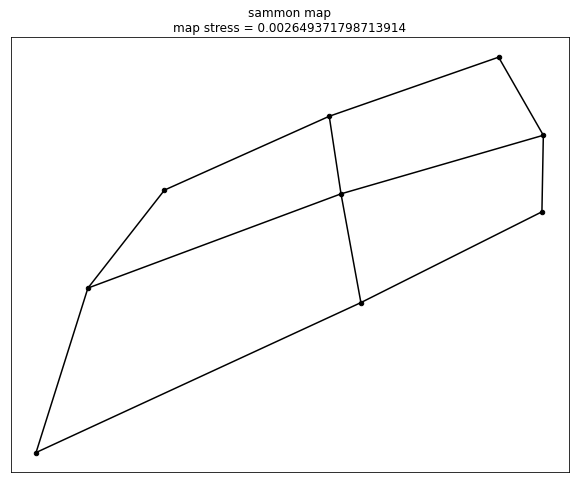

In [37]:
# Calculate sammon coordinates (y) for map and "map stress" (E)
[y,E] = sammon.sammon(som.get_weights().reshape(som_col*som_row, input_length),2,display=1)

# Plot Sammon map nodes
fig = plt.figure(figsize=(10,8))
plt.scatter(y[:,0], y[:,1], s=20, c='black', marker='o')

# Add lines between nodes
tmp = np.reshape(y,(som_col,som_row,2))
len_x, len_y, len_z = tmp.shape
    
# add vertical lines
for i in range(len_x-1):
    for j in range(len_y):
        plt.plot(tmp[i:i+2,j,0],tmp[i:i+2,j,1],c='black')
    
# add horizontal lines
for i in range(len_x):
    for j in range(len_y-1):
        plt.plot(tmp[i,j:j+2,0],tmp[i,j:j+2,1],c='black')  
    
plt.xticks([])
plt.yticks([])
plt.title(r"sammon map" "\n" r"map stress = "+str(E), fontsize=12)
    
# save figure
fout = path_out+fin+'_sammon.png'
plt.savefig(fout, bbox_inches='tight', dpi=200)


## Plot frequencies across lattice

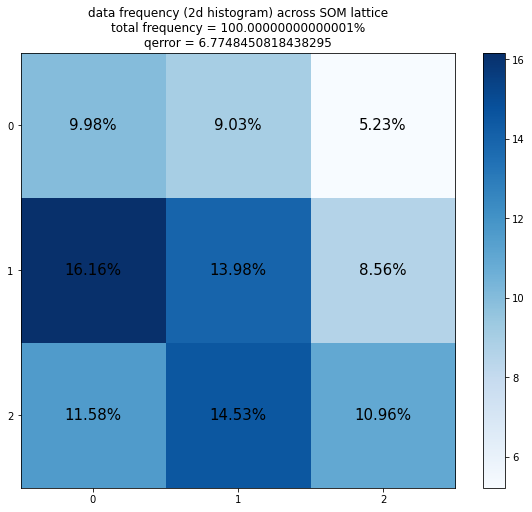

In [38]:
# set frequencies
frequencies = 100.*((som.activation_response(data))/sum(sum(som.activation_response(data))))
#verify the total frequency is 100%
total = sum(sum(frequencies))

# Plot frequencies across SOM lattice
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111)
im = ax.imshow(frequencies, cmap='Blues')   
    
# Loop over data dimensions and create text annotations in each cell
len_x, len_y = frequencies.shape
for i in range(len_x):
    for j in range(len_y):
        text = ax.text(j, i, str(round(frequencies[i, j],2))+'%', fontsize=15,
                       ha="center", va="center", color="k")

# Make cosmetic changes
cbar = plt.colorbar(im)
plt.title(r"data frequency (2d histogram) across SOM lattice" "\n" r"total frequency = "+str(total)+"%" "\n" r"qerror = "+str(qerr), fontsize=12)
plt.xticks(np.arange(0,som_row, 1))
plt.yticks(np.arange(0,som_col, 1))
    
# save figure
fout = path_out+fin+'_freq.png'
plt.savefig(fout, bbox_inches='tight', dpi=200)


## Plot composite maps
Do both ice thickness and concentration to check them

In [39]:
# set region of interest - for plotting
titles     = ['Ross Sea', 'Amundsen Bellingshausen Sea', 'Weddell Sea', 'Pacific Ocean', 'Indian Ocean']
shorts     = ['Ross', 'AMB', 'Wed', 'Pac', 'Ind']
masks      = ['Ross_mask', 'BAm_mask', 'Wed_mask', 'Pac_mask', 'Ind_mask']
lat_maxes  = [-72, -65, -65, -60, -60] 
lat_mins   = [-85, -85, -85, -80, -80]
lon_maxes  = [200, 300, 300, 90, 160] 
lon_mins   = [160, 220, 20, 20, 90]
lon_avgs   = [190, 260, 340, 55, 125]

In [40]:
# Based on sector set at top of script, set plotting limits
ind = shorts.index(sector_short)
sector_title = titles[ind]
mask_in = masks[ind]
lat_max = lat_maxes[ind]
lat_min = lat_mins[ind]
lon_max = lon_maxes[ind]
lon_min = lon_mins[ind]
lon_avg = lon_avgs[ind]

In [48]:
# Load data for larger area than only training area
# this data has been processed all the same 'time' coordinates as training data
vars_composite_in = ['aice_d', 'hi_d']

n = 1
var_composite_in = vars_composite_in[n] 

In [49]:
# set some labeling things
if var_composite_in == 'aice_d':
    title = 'ice concentration' 
    units = 'frac'
    vmin_in = 0
    vmax_in = 1
    ticks_1 = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0] #np.arange(vmin_in,vmax_in,0.2)
if var_composite_in == 'hi_d':
    title = 'ice thickness' 
    units = 'm'
    vmin_in = 0
    vmax_in = 2
    ticks_1 = [0,0.25,0.5,0.75,1.0,1.25,1.5,1.75] #np.arange(vmin_in,vmax_in,0.2)
    

In [50]:
# file name for training variable only here 
fin_training = 'antarctic_data_for_som_composites_'+var_composite_in
# load data
ds = xr.open_mfdataset(path_in+fin_training+'.nc')

In [51]:
# explicitly load data so that it doesn't take forever later on during mean
ds = ds.load()

In [52]:
# create an empty dictionary using the rows and columns of SOM
keys = [i for i in product(range(som_row),range(som_col))]
winmap = {key: [] for key in keys}

In [53]:
# set frequencies
frequencies = 100.*((som.activation_response(data))/sum(sum(som.activation_response(data))))
#verify the total frequency is 100%
total = sum(sum(frequencies))

# grab the indices for the data within the SOM lattice
for i, x in enumerate(data):
    winmap[som.winner(x)].append(i) 

# create list of the dictionary keys
som_keys = list(winmap.keys())
print(f"Number of composite maps: {len(som_keys)}")
print(f"The rows and columns of the SOM lattice to use to grab SOM indexes:\n{[i for i in list(winmap.keys())]}")

Number of composite maps: 9
The rows and columns of the SOM lattice to use to grab SOM indexes:
[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]


/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("bone").copy()
  This is separate from the ipykernel package so we can avoid doing imports until


23173


/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1982: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


20969


/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1982: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


12139


/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1982: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


37539


/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1982: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


32470


/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1982: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


19881


/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1982: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


26906


/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1982: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


33756


/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1982: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


25467


/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1982: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


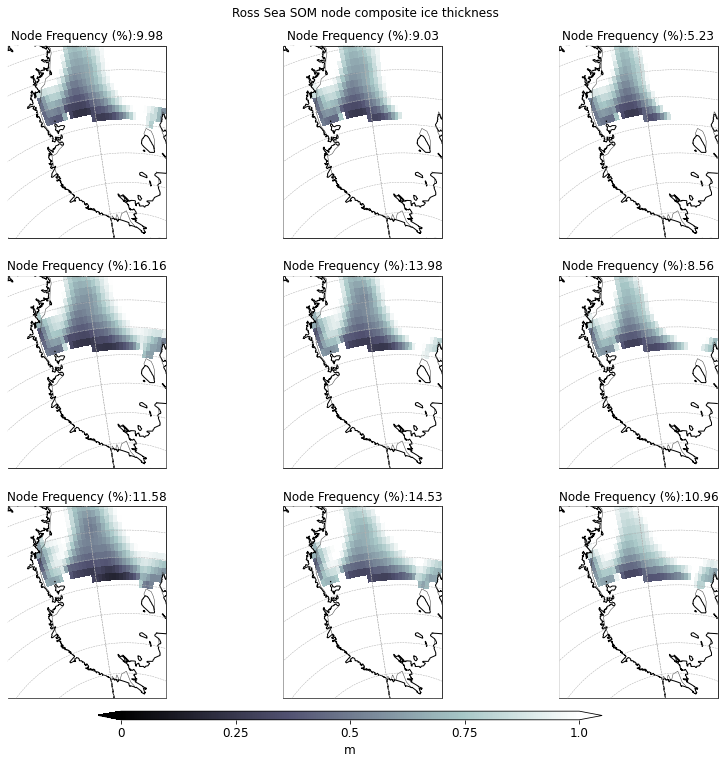

In [54]:
# set some general plotting info
cmap_choice = plt.cm.get_cmap('bone')  #'coolwarm'
cmap_choice.set_bad(color='white')
    
# set some of the plot info
fig, axs = plt.subplots(som_row, som_col, subplot_kw={'projection':ccrs.Stereographic(central_longitude=lon_avg)}, figsize=(14,12))
    
# loop through the different maps to get the indices of training data that map there
for map_num in range(len(som_keys)):
    # get indices of training data that mapped to this node
    inds = winmap[som_keys[map_num]]
    print(len(inds))
    # grab the compositing data that corresponds to those training times
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        ds_sub = ds.isel(training_times=inds)          
    ds_sub = ds_sub.mean(dim="training_times", skipna=True)
        
    # make plot for this node - note using .values converts from xarray to numpy array
    cs = axs[som_keys[map_num][0],som_keys[map_num][1]].pcolor(ds.coords['TLON'].values, 
                                                               ds.coords['TLAT'].values, 
                                                               ds_sub["data"].values, 
                                                               vmin=0, vmax=1, cmap=cmap_choice,
                                                               transform=ccrs.PlateCarree())
        
    axs[som_keys[map_num][0],som_keys[map_num][1]].set_extent([lon_min,lon_max,lat_min,lat_max])
    axs[som_keys[map_num][0],som_keys[map_num][1]].coastlines(resolution='110m', color='0.25', linewidth=0.5, zorder=10)
    axs[som_keys[map_num][0],som_keys[map_num][1]].add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='w')    
    axs[som_keys[map_num][0],som_keys[map_num][1]].gridlines(linestyle='--', linewidth=0.5, zorder=11)
    
    # plot titles
    axs[som_keys[map_num][0],som_keys[map_num][1]].set_title('Node Frequency (%):{:.2f}'.format(frequencies.flatten()[map_num]), fontsize=12)
    
# finalize figure 
plt.suptitle(sector_title+' SOM node composite '+title, fontsize=12, x=0.515, y=0.925)

# colorbar stuff
cbar_ax = fig.add_axes([0.25,0.1,0.5,0.01]) 
cbar = fig.colorbar(cs, cax=cbar_ax, ticks=ticks_1[:],
                    orientation='horizontal', extend='both')
cbar.ax.set_xticklabels(list(ticks_1))
cbar.ax.tick_params(labelsize=12)
cbar.set_label(units, fontsize=12)
    
# save figure
fout = path_out+fin+'_'+var_composite_in+'_composite.png'
plt.savefig(fout, bbox_inches='tight', dpi=200)
